
# Descriptive Operations & CRM KPIs

## 1. Order & Fulfillment Overview

* Q1: What are the daily, weekly, and monthly order volumes?

* Q2: What is the average fulfillment cycle time (order → delivery) over time?

* Q3: What percentage of orders are delivered on time (OTD %)?

*  Q4: How does return rate vary by product category and month?

## 2. Inventory & Returns

* Q5: How do inventory levels fluctuate relative to order peaks?


## 3. High-Level CRM Descriptives

* Q6: Overall open rate, click-through rate (CTR) and unsubscribe rate by channel.

* Q7: Open/CTR/unsubscribe broken out by customer segment (new vs. repeat vs. inactive).

* Q8: Open/CTR/unsubscribe by age group and region.



In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

customers_df = pd.read_csv('../data/customers.csv')

inventory_df= pd.read_csv('../data/inventory.csv')
orders_df= pd.read_csv('../data/orders.csv')
returns_df= pd.read_csv('../data/returns.csv')
shipments_df = pd.read_csv('../data/shipments.csv')
time_dim=pd.read_csv('../data/time_dim.csv')
products_df = pd.read_csv('../data/products.csv')



In [2]:
import pandas as pd

email_campaign_df = pd.read_csv('../data/email_campaigns.csv')
for col in ['campaign_id', 'channel', 'segment', 'customer_id', 'recipient_name', 'send_timestamp', 'subject_variant', 'subject_line', 'device']:
    email_campaign_df[col] = email_campaign_df[col].astype('string')

email_engagement_df = pd.read_csv('../data/email_engagement.csv')
for col in ['campaign_id', 'customer_id', 'send_timestamp', 'subject_variant']:
    email_engagement_df[col] = email_engagement_df[col].astype('string')




# Convert timestamps
email_campaign_df['send_timestamp'] = pd.to_datetime(email_campaign_df['send_timestamp'], errors='coerce')
email_engagement_df['send_timestamp'] = pd.to_datetime(email_engagement_df['send_timestamp'], errors='coerce')




In [3]:
# 10% sample of 10 million rows 
email_campaign_df = email_campaign_df.sample(frac=0.10, random_state=42)
filtered_keys = email_campaign_df[['campaign_id', 'customer_id', 'send_timestamp']]

email_engagement_df = email_engagement_df.merge(
    filtered_keys,
    on=['campaign_id', 'customer_id', 'send_timestamp'],
    how='inner'
)


## 1. Order & Fulfillment Overview

 ### Q1: What are the daily, weekly, and monthly order volumes?

In [4]:
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], errors='coerce')



## Daily 
daily_orders = (
    orders_df.groupby(orders_df['order_date'].dt.date).size()
)
daily_orders.describe()

## weekly (iso week)

weekly_orders = (
    orders_df.groupby(orders_df['order_date'].dt.isocalendar().week).size()
)

weekly_orders.describe()

## MOnthly order count
monthly_orders = (
    orders_df.groupby(orders_df['order_date'].dt.to_period('M')).size()

)

monthly_orders.describe()

count      14.000000
mean     3201.142857
std      2368.334853
min         3.000000
25%      1265.500000
50%      3015.000000
75%      4898.750000
max      7154.000000
dtype: float64

### Q2: What is the average fulfillment cycle time (order → delivery) over time?

In [5]:
orders_df['order_date']= pd.to_datetime(orders_df['order_date'],errors='coerce')
shipments_df['delivery_date']= pd.to_datetime(shipments_df['delivery_date'],errors='coerce')


merge_order_shipment = pd.merge(orders_df,shipments_df,on='order_id', how='left')


merge_order_shipment['fulfillment_days']=(
    merge_order_shipment['delivery_date']-merge_order_shipment['order_date']
).dt.days

## Filter out impossible dates such as delivery_date before order date
merge_order_shipment = merge_order_shipment[
    (merge_order_shipment['fulfillment_days'].notna()) &
    (merge_order_shipment['fulfillment_days'] >= 0)
]
avg_fulfillment_by_month =(
    merge_order_shipment.groupby(merge_order_shipment['order_date'].dt.to_period('M'))['fulfillment_days'].mean()
    
)

avg_fulfillment_by_month.describe()

count    12.000000
mean      8.020296
std       0.404433
min       6.827493
25%       7.998440
50%       8.063641
75%       8.239585
max       8.410120
Name: fulfillment_days, dtype: float64

### Q3: What percentage of orders are delivered on time (OTD %)?

In [6]:
## Total orders 
total_orders = len(merge_order_shipment)
## 1 means it was delivered on time 
## 0 means late delivery
on_time_orders = merge_order_shipment['on_time_flag'].sum()

otd_percentage = (on_time_orders/total_orders)*100

print(f"On time delivery precentage : {round(otd_percentage,2)}%")


On time delivery precentage : 81.14%


### Q4: How does return rate vary by product category and month?

In [7]:
## orders by category and month 
orders_df['order_date']= pd.to_datetime(orders_df['order_date'],errors='coerce')

orders_cat_month = (
    orders_df
    .groupby([orders_df['product_category'], orders_df['order_date'].dt.to_period('M').rename('order_month')])
    .size()
    .reset_index(name='total_orders')
)

merge_product_returns= pd.merge(returns_df,orders_df,on='order_id', how='left')

merge_product_returns['order_date']= pd.to_datetime(merge_product_returns['order_date'],errors='coerce')

returs_cat_month = (
    merge_product_returns
    .groupby([merge_product_returns['product_category'],merge_product_returns['order_date'].dt.to_period('M').rename('order_month')])
    .size()
    .reset_index(name='returned_orders')
)


## merge calculate return rate 
return_rate_df = orders_cat_month.merge(returs_cat_month, on=['product_category','order_month'], how='left')

return_rate_df['returned_orders'] = return_rate_df['returned_orders'].fillna(0)

return_rate_df['return_rate']= (return_rate_df['returned_orders'] / return_rate_df['total_orders']) * 100

return_rate_df.head(25).sort_values(by='order_month',ascending=True)


,product_category,order_month,total_orders,returned_orders,return_rate
0,Accessories,2024-07,2,0.0,0.000000
13,Activewear,2024-07,6,0.0,0.000000
14,Activewear,2024-08,15,2.0,13.333333
1,Accessories,2024-08,3,0.0,0.000000
2,Accessories,2024-09,17,0.0,0.000000
15,Activewear,2024-09,34,5.0,14.705882
3,Accessories,2024-10,18,0.0,0.000000
16,Activewear,2024-10,35,4.0,11.428571
17,Activewear,2024-11,48,7.0,14.583333
4,Accessories,2024-11,23,3.0,13.043478


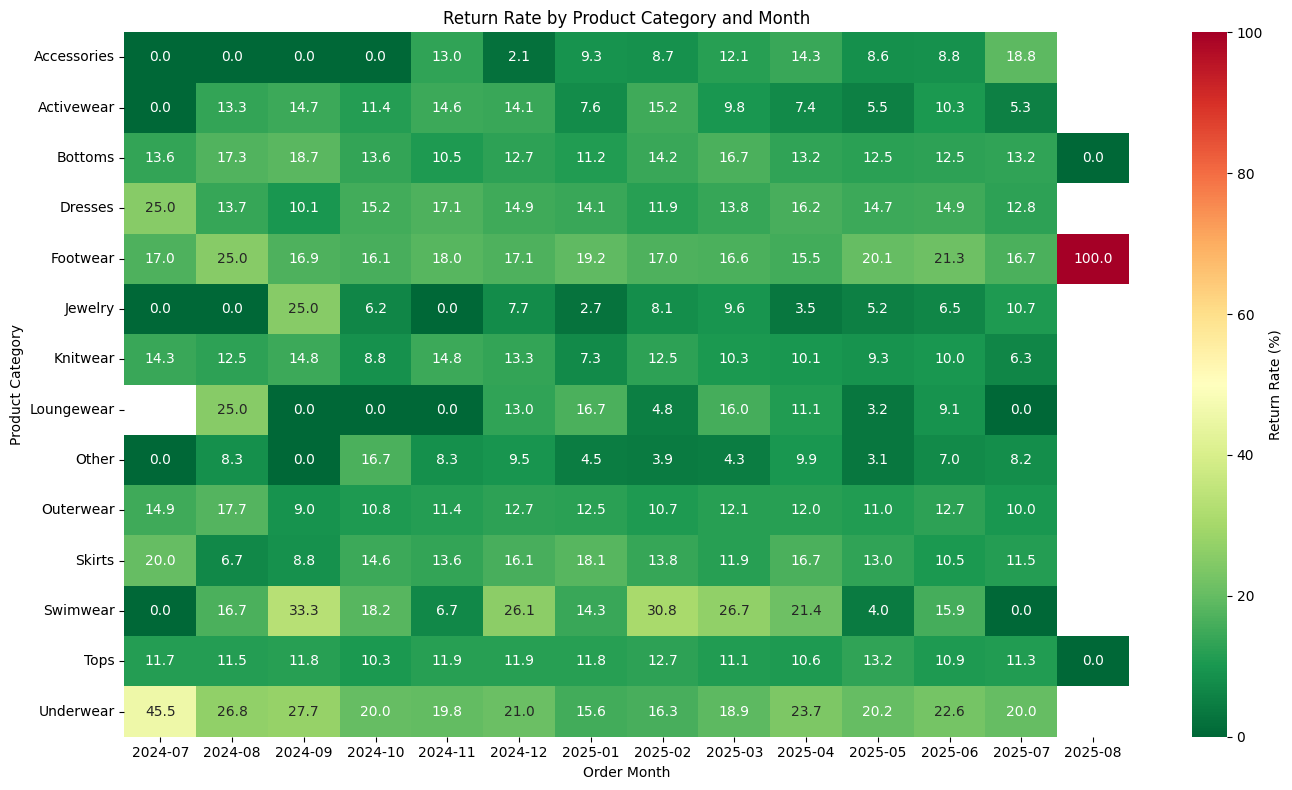

In [8]:


# Pivot for heatmap
heatmap_data = return_rate_df.pivot(
    index='product_category',
    columns='order_month',
    values='return_rate'
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn_r",
    cbar_kws={'label': 'Return Rate (%)'}
)

plt.title('Return Rate by Product Category and Month')
plt.xlabel('Order Month')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()



#### Summary of Return rate heatmap

This heatmap displays return rates (%) across product categories and months. Underwear consistently has high return rates, exceeding 45% in certain months. Swimwear returns fluctuate significantly, with spikes such as 33% in September 2024 and 30% in February 2025. Categories including Accessories, Jewelry, and Loungewear generally maintain low return rates, mostly below 15%. Return rates vary month-to-month for most categories, reflecting seasonality or shifts in customer behavior. Empty cells indicate no orders or returns recorded for that category and month.

## 2. Inventory & Returns

###  Q5: How do inventory levels fluctuate relative to order peaks?

In [9]:
orders_df['order_date']= pd.to_datetime(orders_df['order_date'],errors='coerce')

order_quantity_month = (
orders_df
.groupby(orders_df['order_date'].dt.to_period('M').rename('order_months'))['quantity'].sum()
.reset_index(name='total_quantity')
)

inventory_df['date']=  pd.to_datetime(inventory_df['date'],errors='coerce')
inventory_stocks = (
    inventory_df
    .groupby(inventory_df['date'].dt.to_period('M').rename('order_months'))
    .agg({
        'stock_on_hand':'sum',
        'stock_inbound':'sum'
    }).rename(columns={
        'stock_on_hand':'total_stock_on_hand'
    })

)



merge_order_inventory= pd.merge(order_quantity_month,inventory_stocks,on='order_months',how='left')



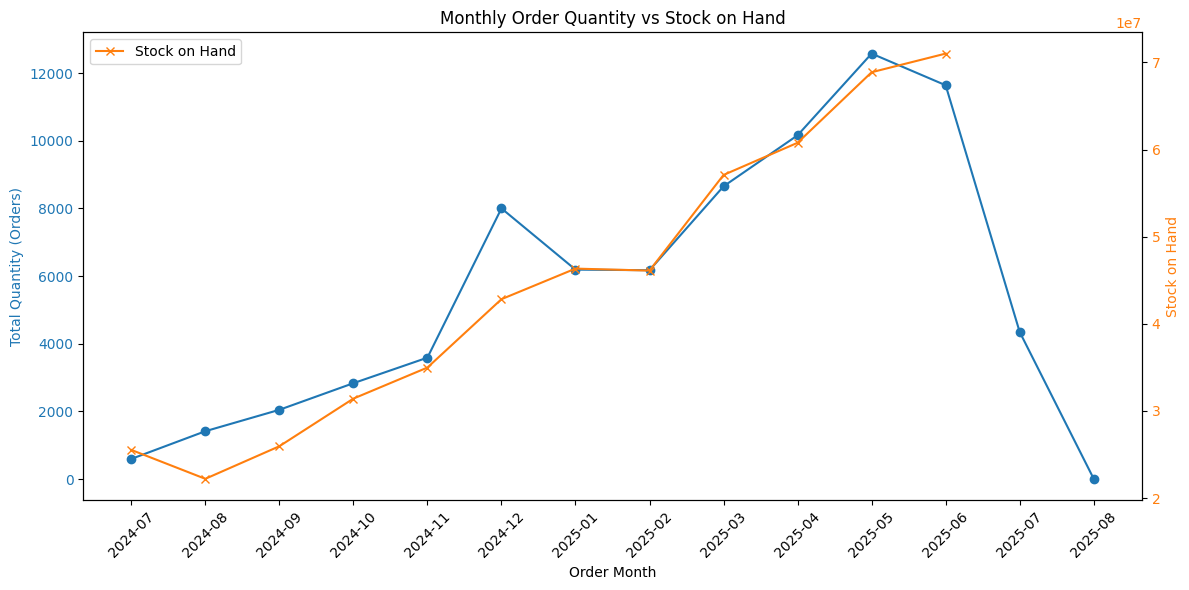

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Order Month')
ax1.set_ylabel('Total Quantity (Orders)', color='tab:blue')
ax1.plot(merge_order_inventory['order_months'].astype(str), merge_order_inventory['total_quantity'], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Stock on Hand', color='tab:orange')
ax2.plot(merge_order_inventory['order_months'].astype(str), merge_order_inventory['total_stock_on_hand'], label='Stock on Hand', color='tab:orange', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax2.legend(loc='upper left')

plt.title('Monthly Order Quantity vs Stock on Hand')
plt.tight_layout()
plt.show()




### **Inventory-Order Relationship Analysis**

The chart shows that inventory levels generally grow alongside order volumes, though there are periods where demand outpaces our available stock.

From July 2024 through May 2025, we can see both metrics rising together in a fairly synchronized pattern. The inventory management system appears to respond to increasing demand by building up stock levels accordingly. However, there are some notable exceptions where orders surge beyond our immediate inventory capacity.

In December 2024, orders spiked to around 8,000 units while we only had about 4,500 units in stock, creating a clear gap between demand and supply. Similarly, in June 2025, peak orders reached approximately 11,500 units, which drew down our inventory levels significantly despite having built up stock to around 70,000 units.

The data also reveals periods of strategic inventory building. During January and February 2025, orders plateaued while inventory continued growing, creating a buffer for future demand. By July 2025, when orders dropped to around 4,500 units, we maintained high inventory levels of about 72,000 units, providing substantial capacity for anticipated demand increases.

Overall, the relationship demonstrates a reactive inventory management approach where stock levels scale with demand patterns, though occasional demand surges can temporarily exceed our immediate inventory availability. The company appears to use lower-demand periods to rebuild inventory buffers for future peak periods.

*Note: August 2025 data appears incomplete and has been excluded from this analysis.*

## 3. High-Level CRM Descriptives

### Q6: Overall open rate, click-through rate (CTR) and unsubscribe rate by channel.

In [12]:
# Get campaign_ids in engagement
## 10 million rows of data cannot be merged without getting memeory allocation issues
## we need to aggregate it first 
## Aggregate engagement first 
agg_eng = email_engagement_df.groupby('campaign_id').agg(
    opens=('opened', 'sum'),
    clicks=('clicked', 'sum'),
    unsubscribes=('unsubscribed', 'sum'),
    total_sent=('customer_id', 'count')
).reset_index()

campaigns_info = email_campaign_df[['campaign_id', 'channel']].drop_duplicates()

merge_campaign_engagement = pd.merge(agg_eng, campaigns_info, on='campaign_id', how='inner')






In [14]:

### now to answer the question we will aggregate by channel 
channel_stats = (
    merge_campaign_engagement
    .groupby('channel')
    .agg(
        total_sent=('total_sent','sum'),
        total_opens=('opens','sum'),
        total_clicks=('clicks','sum'),
        total_unsubscribes=('unsubscribes','sum')
    )
    .reset_index()
)


channel_stats['open_rate']= channel_stats['total_opens']/channel_stats['total_sent']
channel_stats['clicks_rate']= channel_stats['total_clicks']/channel_stats['total_sent']
channel_stats['unsubscribe_rate']= channel_stats['total_unsubscribes']/channel_stats['total_sent']




channel_stats.head(10)

,channel,total_sent,total_opens,total_clicks,total_unsubscribes,open_rate,clicks_rate,unsubscribe_rate
0,event,30050,3075,99,106,0.102329,0.003295,0.003527
1,loyalty,49225,5793,223,180,0.117684,0.004530,0.003657
2,newsletter,467402,48400,1660,1712,0.103551,0.003552,0.003663
3,promo,856987,97711,3679,3054,0.114017,0.004293,0.003564
4,survey,18455,1994,63,64,0.108047,0.003414,0.003468
5,transactional,146513,15691,551,535,0.107096,0.003761,0.003652


Promo and loyalty emails show slightly higher click rates (~0.43-0.45%) than other channels (~0.33–0.38%), but the differences are marginal. No channel stands out as a clear outlier in performance.

### Q7: Open/CTR/unsubscribe broken out by customer segment (new vs. repeat vs. inactive).

In [15]:
cols_needed = ['customer_id', 'send_timestamp', 'purchase']
df = email_engagement_df[cols_needed].copy()


df['customer_id'] = df['customer_id'].astype('category')

df['purchase'] = df['purchase'].astype('int8')
df['send_timestamp'] = pd.to_datetime(df['send_timestamp'])

## sort the values by sned timestamp
df.sort_values(['customer_id', 'send_timestamp'], inplace=True)

## identify first row per customer 
df['is_first']= df.groupby('customer_id',observed=True).cumcount()==0

## has any prior purchase? 
df['prior_purchase']= ( 
    df.groupby('customer_id',observed=True)['purchase']
    .transform(lambda x: x.shift().cummax().fillna(0)))

## assing segments 
df['segment']='inactive'
df.loc[df['is_first'],'segment']= 'new'

# if customer is not new and has prior purchase then they are a repat  
df.loc[(~df['is_first']) & (df['prior_purchase']>0),'segment']='repeat'




In [16]:
cols_needed= ['customer_id','send_timestamp','campaign_id','opened','clicked','unsubscribed']


## Convert the types to help with memery manegement 
email_engagement_df['customer_id'] = email_engagement_df['customer_id'].astype('category')
email_engagement_df['opened'] = email_engagement_df['opened'].astype('int8')
email_engagement_df['clicked'] = email_engagement_df['clicked'].astype('int8')
email_engagement_df['unsubscribed'] = email_engagement_df['unsubscribed'].astype('int8')

engagement_df = email_engagement_df[cols_needed].copy()

engagement_df['send_timestamp']= pd.to_datetime(engagement_df['send_timestamp'],errors='coerce')
full_customer_segment = engagement_df.merge(df,on=['customer_id','send_timestamp'],how='left')


## aggregate by segment 
agg= (
    full_customer_segment
    .groupby('segment')
    .agg({
        'opened':'sum',
        'clicked':'sum',
        'unsubscribed':'sum',
        'campaign_id':'count'
    }).rename(columns={'campaign_id':'email_sent'})
      )


agg['open_rate']= agg['opened']/agg['email_sent']

agg['ctr']= agg['clicked']/agg['email_sent']

agg['unsubscribe_rate']= agg['unsubscribed']/agg['email_sent']



In [17]:
agg.head(10)

,opened,clicked,unsubscribed,email_sent,open_rate,ctr,unsubscribe_rate
segment,,,,,,,
inactive,316612,11092,10323,2848506,0.111150,0.003894,0.003624
new,1032,18,98,15475,0.066688,0.001163,0.006333
repeat,11060,986,170,63275,0.174793,0.015583,0.002687


#### Q7 Summary

**Repeat customers**  
- Open rate: 17.48% – highest among all segments  
- CTR: 1.56% – highest engagement  
- Unsubscribe rate: 0.27% – lowest churn risk  

**Inactive customers**  
- Open rate: 11.12%  
- CTR: 0.39%  
- Unsubscribe rate: 0.36% – higher than repeat, lower than new  

**New customers**  
- Open rate: 6.67% – lowest attention  
- CTR: 0.12% – lowest engagement  
- Unsubscribe rate: 0.63% – highest opt-out rate



###  Q8: Open/CTR/unsubscribe by age group and region.

In [18]:
##merge to get age and region 
engagement_with_demo = full_customer_segment.merge(
    customers_df[['customer_id', 'age', 'region']],
    on='customer_id',
    how='left'
)

In [19]:


bins = [0, 24, 34, 44, 54, 64, 200]
labels = ['<25', '25-34', '35-44', '45-54', '55-64', '65+']
engagement_with_demo['age_group'] = pd.cut(engagement_with_demo['age'], bins=bins, labels=labels, right=True)

agg_segments = (
    engagement_with_demo
    .groupby(['age_group','region'])
    .agg({
        'opened':'sum',
        'clicked':'sum',
        'unsubscribed':'sum',
        'campaign_id':'count'
    }).rename(columns= {'campaign_id':'emails_sent'})
)


agg_segments['open_rate']=agg_segments['opened']/ agg_segments['emails_sent']

agg_segments['ctr']=agg_segments['clicked']/ agg_segments['emails_sent']

agg_segments['unsubscribed_rate']=agg_segments['unsubscribed']/ agg_segments['emails_sent']

C:\Users\yeahm\AppData\Local\Temp\ipykernel_17984\3034449252.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_group','region'])


In [20]:
agg_segments.head(5)

opened  clicked  unsubscribed  emails_sent  \
age_group region                                                        
<25       East of England    3539      167           131        31205   
          London            10512      420           348        95607   
          Midlands           5353      204           176        48856   
          North East         2704       77            82        24477   
          North West         4507      132           112        37925   

                           open_rate       ctr  unsubscribed_rate  
age_group region                                                   
<25       East of England   0.113411  0.005352           0.004198  
          London            0.109950  0.004393           0.003640  
          Midlands          0.109567  0.004176           0.003602  
          North East        0.110471  0.003146           0.003350  
          North West        0.118840  0.003481           0.002953

C:\Users\yeahm\AppData\Local\Temp\ipykernel_17984\824587859.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


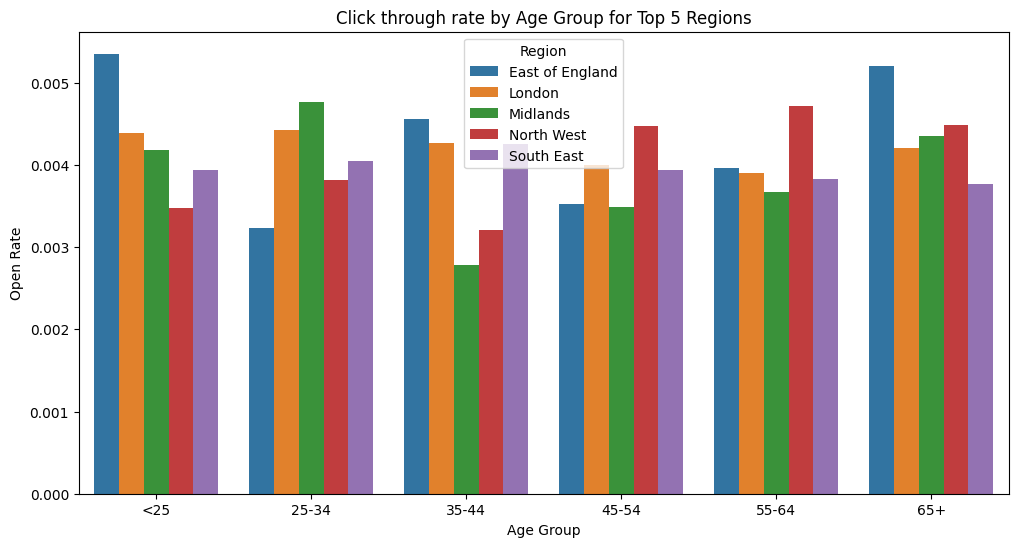

In [21]:

# If agg_segments has multi-index, reset index first
agg_segments_reset = agg_segments.reset_index()

# Find top 5 regions by total emails sent
top_regions = (
    agg_segments_reset
    .groupby('region')['emails_sent']
    .sum()
    .nlargest(5)
    .index
    .tolist()
)

filtered_df = agg_segments_reset[agg_segments_reset['region'].isin(top_regions)]

plt.figure(figsize=(12,6))
sns.barplot(
    data=filtered_df,
    x='age_group',
    y='ctr',
    hue='region',
    ci=None
)
plt.title('Click through rate by Age Group for Top 5 Regions')
plt.ylabel('Open Rate')
plt.xlabel('Age Group')
plt.legend(title='Region')
plt.show()


#### *CTR Summary*

Click-through rates range from 0.0035 to 0.005.

East of England peaks in the 35–44 age group but underperforms in most others.

Midlands leads in the <25 and 65+ segments, but drops sharply for 35–44.

London maintains consistently above-average CTR across all age groups.

North West performs best in 25–34, 55–64, and particularly excels in the 65+ group.

South East shows stable CTR but ranks lowest in <25 and 65+ cohorts.

CTR variation by age and region is modest. No clear trend across age groups.
